<a href="https://colab.research.google.com/github/BuczynskiRafal/pipe_calculations/blob/main/OOP_Catchments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install extensions

In [1]:
!pip install pyswmm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 2.5 MB/s 
     |████████████████████████████████| 458 kB 43.6 MB/s 
     |████████████████████████████████| 131 kB 39.6 MB/s 
  Created wheel for julian: filename=julian-0.14-py3-none-any.whl size=2633 sha256=56fc01c6b4173ff0c7054c8977e4c5209374b0e891523ae9b76a4f645ae113f9
  Stored in directory: /root/.cache/pip/wheels/bb/58/2a/4109ff5870c163b26a499fb8b828ede50e96264571a4f082d3
Successfully built julian


# Import extensions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyswmm import Simulation, Nodes, Links, Subcatchments, Output

# prepare methoed for sumulation

In [34]:
with Simulation('example.inp') as sim:
    c3 = Links(sim)["C3"]
    for step in sim:
        pass
    print(f"C3 flow: {c3.flow}")
    print(f"C3 flow_limit: {c3.flow_limit}")
    print(f"C3 average_head_loss: {c3.average_head_loss}")
    print(f"C3 current_setting: {c3.current_setting}")
    print(f"C3 depth: {c3.depth}")
    print(f"C3 ds_xsection_area: {c3.ds_xsection_area}")
    print(f"C3 froude: {c3.froude}")
    print(f"C3 initial_flow: {c3.initial_flow}")
    print(f"C3 volume: {c3.volume}")
    print(f"C3 conduit_statistics: {c3.conduit_statistics}")
    print(f"C3 : {dir(c3)}")
    

C3 flow: 0.006495579053585256
C3 flow_limit: 0.0
C3 average_head_loss: 0.0
C3 current_setting: 1.0
C3 depth: 0.058351315940755766
C3 ds_xsection_area: 7.918961924847853
C3 froude: 0.8075818638863735
C3 initial_flow: 0.0
C3 volume: 0.6427907913678443
C3 conduit_statistics: {'flow_turn_sign': -1, 'flow_turns': 4, 'peak_depth': 0.49999999999999994, 'peak_flow': 0.6236029253726476, 'peak_flow_date': 44729.023377233796, 'peak_velocity': 3.1756299756888065, 'time_capacity_limited': 1.883469166666667, 'time_courant_crit': 0.020277777777777777, 'time_full_downstream': 1.883469166666667, 'time_full_flow': 2.134078611111112, 'time_full_upstream': 1.9364150000000002, 'time_in_flow_class': <Swig Object of type 'DateTime *' at 0x7fcebecb3120>, 'time_inlet_control': 0.0, 'time_normal_flow': 0.0, 'time_surcharged': 1.883469166666667}
C3 : ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subcl

In [23]:
class PipeData:
    def __init__(self):
        self.flow_turn_sign = []
        self.flow_turns = []
        self.peak_depth = []
        self.peak_flow = []
        self.peak_flow_date = []
        self.peak_velocity = []
        self.time_capacity_limited = []
        self.time_courant_crit = []
        self.time_full_downstream = []
        self.time_full_flow = []
        self.time_full_upstream = []
        self.time_normal_flow = []


class CatchmentData:
    def __init__(self):
        self.runoff = []
        self.peak_runoff_rate = []
        self.infiltration = []
        self.evaporation = []


class Analyse:
    def __init__(self, file_path='example.inp'):
        self.pipe_data = PipeData()
        self.catchment_data = CatchmentData()
        self.slope = []
        self._file_path = file_path

    def show_subcatchment(self):
        with Simulation(self._file_path) as sim:
            return [subcatchment.subcatchmentid for subcatchment in Subcatchments(sim)]

    def show_conduits(self):
        with Simulation(self._file_path) as sim:
            return [conduit.linkid for conduit in Links(sim)]

    def simulation(self, conduit_id=None, subcatchment_id=None, min_slope=0.1, max_slope=100, step=0.1):
        counter = min_slope
        while counter < max_slope:
            self.slope.append(counter)
            with Simulation(self._file_path) as sim:
                conduit = Links(sim)[conduit_id]
                catchment = Subcatchments(sim)[subcatchment_id]
                catchment.slope = counter
                for _ in sim:
                    pass
                conduit_stats = conduit.conduit_statistics
                catchment_stats = catchment.statistics
                for key in vars(self.pipe_data):
                    getattr(self.pipe_data, key).append(conduit_stats[key])
                for key in vars(self.catchment_data):
                    getattr(self.catchment_data, key).append(catchment_stats[key])
            counter += step
        return None

# Do simulation

In [4]:
pipe = Analyse()
pipe.simulation("C3", "S1")

# Prepare dataframe



In [5]:
data = {"slope": pipe.slope, **vars(pipe.pipe_data), **vars(pipe.catchment_data)}
df_raw = pd.DataFrame(data=data)

# Data for work

In [6]:
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   slope                  1000 non-null   float64
 1   flow_turn_sign         1000 non-null   int64  
 2   flow_turns             1000 non-null   int64  
 3   peak_depth             1000 non-null   float64
 4   peak_flow              1000 non-null   float64
 5   peak_flow_date         1000 non-null   float64
 6   peak_velocity          1000 non-null   float64
 7   time_capacity_limited  1000 non-null   float64
 8   time_courant_crit      1000 non-null   float64
 9   time_full_downstream   1000 non-null   float64
 10  time_full_flow         1000 non-null   float64
 11  time_full_upstream     1000 non-null   float64
 12  time_normal_flow       1000 non-null   float64
 13  runoff                 1000 non-null   float64
 14  peak_runoff_rate       1000 non-null   float64
 15  infil

In [7]:
df.head()

,slope,flow_turn_sign,flow_turns,peak_depth,peak_flow,peak_flow_date,peak_velocity,time_capacity_limited,time_courant_crit,time_full_downstream,time_full_flow,time_full_upstream,time_normal_flow,runoff,peak_runoff_rate,infiltration,evaporation
0,0.1,-1,1,0.5,0.623562,44729.023184,3.175424,1.772424,0.018333,1.772424,2.005563,1.823684,0.0,4950.427329,1.383118,78.686507,0.0
1,0.2,-1,6,0.5,0.623603,44729.023046,3.175633,1.763621,0.019444,1.763621,1.992927,1.814004,0.0,4960.083361,1.383174,72.182802,0.0
2,0.3,-1,6,0.5,0.623574,44729.023008,3.175481,1.760935,0.019444,1.760935,1.991863,1.811549,0.0,4965.240052,1.383161,68.951701,0.0
3,0.4,-1,6,0.5,0.623562,44729.022983,3.175422,1.757170,0.019167,1.757170,1.986720,1.807678,0.0,4968.871979,1.383200,66.876791,0.0
4,0.5,-1,6,0.5,0.623640,44729.022921,3.175817,1.755641,0.020278,1.755641,1.988856,1.805961,0.0,4971.489667,1.383214,65.392838,0.0


In [8]:
df.shape

(1000, 17)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
slope,1000.0,50.050000,28.881944,0.100000,25.075000,50.050000,75.025000,100.000000
flow_turn_sign,1000.0,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
flow_turns,1000.0,4.989000,0.914174,1.000000,5.000000,5.000000,6.000000,6.000000
peak_depth,1000.0,0.500000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000
peak_flow,1000.0,0.623520,0.000032,0.623458,0.623516,0.623529,0.623530,0.623640
peak_flow_date,1000.0,44729.022825,0.000064,44729.022611,44729.022795,44729.022799,44729.022813,44729.023184
peak_velocity,1000.0,3.175209,0.000161,3.174890,3.175189,3.175255,3.175258,3.175817
time_capacity_limited,1000.0,1.752382,0.001123,1.750562,1.751695,1.752738,1.752822,1.772424
time_courant_crit,1000.0,0.019248,0.000495,0.018056,0.019167,0.019444,0.019444,0.020556
time_full_downstream,1000.0,1.752384,0.001124,1.750562,1.751695,1.752738,1.752823,1.772424


# Remove unused columns

In [10]:
df.columns

Index(['slope', 'flow_turn_sign', 'flow_turns', 'peak_depth', 'peak_flow',
       'peak_flow_date', 'peak_velocity', 'time_capacity_limited',
       'time_courant_crit', 'time_full_downstream', 'time_full_flow',
       'time_full_upstream', 'time_normal_flow', 'runoff', 'peak_runoff_rate',
       'infiltration', 'evaporation'],
      dtype='object')

In [11]:
df.head()

,slope,flow_turn_sign,flow_turns,peak_depth,peak_flow,peak_flow_date,peak_velocity,time_capacity_limited,time_courant_crit,time_full_downstream,time_full_flow,time_full_upstream,time_normal_flow,runoff,peak_runoff_rate,infiltration,evaporation
0,0.1,-1,1,0.5,0.623562,44729.023184,3.175424,1.772424,0.018333,1.772424,2.005563,1.823684,0.0,4950.427329,1.383118,78.686507,0.0
1,0.2,-1,6,0.5,0.623603,44729.023046,3.175633,1.763621,0.019444,1.763621,1.992927,1.814004,0.0,4960.083361,1.383174,72.182802,0.0
2,0.3,-1,6,0.5,0.623574,44729.023008,3.175481,1.760935,0.019444,1.760935,1.991863,1.811549,0.0,4965.240052,1.383161,68.951701,0.0
3,0.4,-1,6,0.5,0.623562,44729.022983,3.175422,1.757170,0.019167,1.757170,1.986720,1.807678,0.0,4968.871979,1.383200,66.876791,0.0
4,0.5,-1,6,0.5,0.623640,44729.022921,3.175817,1.755641,0.020278,1.755641,1.988856,1.805961,0.0,4971.489667,1.383214,65.392838,0.0


In [12]:
df.drop(columns=['flow_turn_sign', 'flow_turns', 'time_capacity_limited', 'time_courant_crit', 'time_full_downstream', 'time_full_upstream'], axis=1, inplace=True)
df.head()

,slope,peak_depth,peak_flow,peak_flow_date,peak_velocity,time_full_flow,time_normal_flow,runoff,peak_runoff_rate,infiltration,evaporation
0,0.1,0.5,0.623562,44729.023184,3.175424,2.005563,0.0,4950.427329,1.383118,78.686507,0.0
1,0.2,0.5,0.623603,44729.023046,3.175633,1.992927,0.0,4960.083361,1.383174,72.182802,0.0
2,0.3,0.5,0.623574,44729.023008,3.175481,1.991863,0.0,4965.240052,1.383161,68.951701,0.0
3,0.4,0.5,0.623562,44729.022983,3.175422,1.986720,0.0,4968.871979,1.383200,66.876791,0.0
4,0.5,0.5,0.623640,44729.022921,3.175817,1.988856,0.0,4971.489667,1.383214,65.392838,0.0


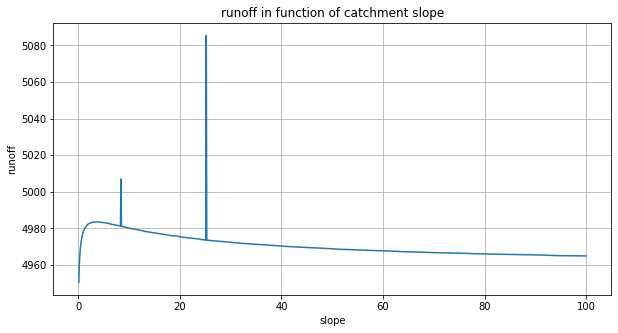

In [13]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['runoff'])
plt.title('runoff in function of catchment slope')
plt.xlabel('slope')
plt.ylabel('runoff')
plt.grid(True)
plt.show()

# Plot peak runoff rate data

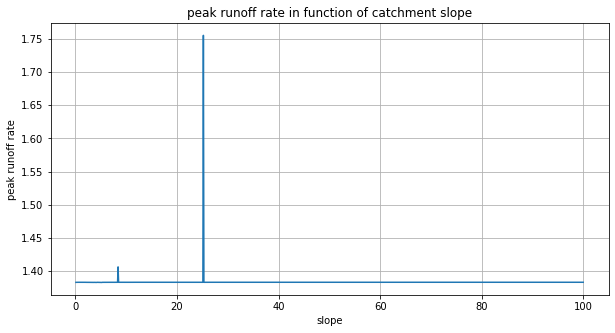

In [14]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_runoff_rate'])
plt.title('peak runoff rate in function of catchment slope')
plt.xlabel('slope')
plt.ylabel('peak runoff rate')
plt.grid(True)
plt.show()

# Plot infiltration data

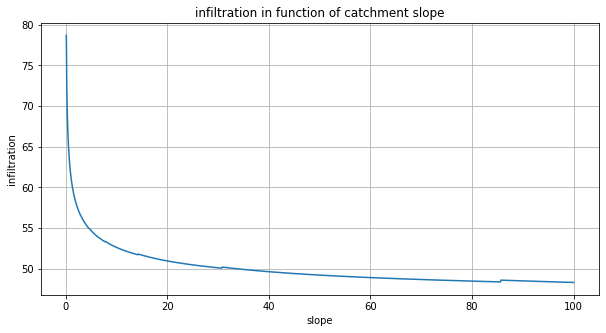

In [15]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['infiltration'])
plt.title('infiltration in function of catchment slope')
plt.xlabel('slope')
plt.ylabel('infiltration')
plt.grid(True)
plt.show()

# Plot pipe flow

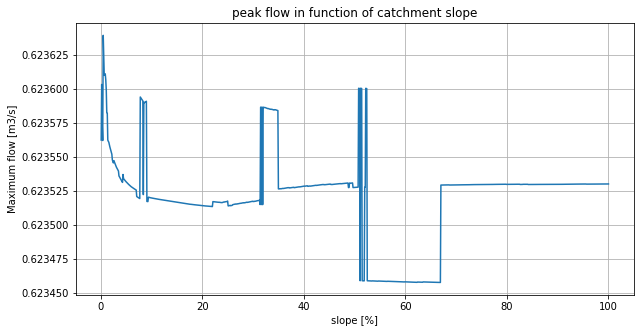

In [35]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_flow'])
plt.title('peak flow in function of catchment slope')
plt.xlabel('slope [%]')
plt.ylabel('Maximum flow [m3/s]')
plt.grid(True)
plt.show()

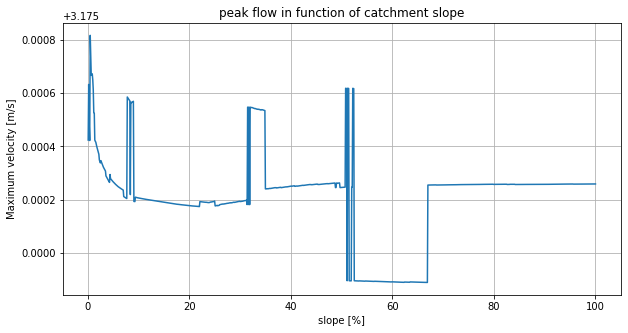

In [36]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_velocity'])
plt.title('peak flow in function of catchment slope')
plt.xlabel('slope [%]')
plt.ylabel('Maximum velocity [m/s]')
plt.grid(True)
plt.show()